In [1]:
import torch

In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

In [3]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

In [4]:
# install for train and test
root = './'
train = MNIST(root, train=True, transform=data_tfs, download=True)
test = MNIST(root, train=False, transform=data_tfs, download=True)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


In [6]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [7]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [8]:
features = 784
classes = 10

In [9]:
W = torch.FloatTensor(features, classes).uniform_(-1, 1) / features**0.5
W.requires_grad_()

tensor([[ 0.0229,  0.0106,  0.0160,  ...,  0.0134,  0.0170, -0.0258],
        [-0.0006,  0.0325, -0.0046,  ..., -0.0068, -0.0314,  0.0026],
        [-0.0172,  0.0213, -0.0288,  ...,  0.0125, -0.0181, -0.0285],
        ...,
        [ 0.0225, -0.0107, -0.0202,  ...,  0.0219,  0.0324,  0.0037],
        [-0.0068,  0.0185, -0.0314,  ...,  0.0320,  0.0140, -0.0213],
        [ 0.0094,  0.0259,  0.0095,  ..., -0.0349,  0.0165,  0.0146]],
       requires_grad=True)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [11]:
epochs = 3
lr = 1e-2
history = []

In [12]:
import numpy as np
from torch.nn.functional import cross_entropy

In [13]:
for i in range(epochs):
    for x_batch, y_batch in train_loader:
        # load batches of data correctly
        x_batch = x_batch.reshape(x_batch.shape[0], -1)
        y_batch = y_batch

        # compute loss (log loss a.k.a. cross entropy)
        logits = x_batch @ W
        probabilities = torch.exp(logits) / torch.exp(logits).sum(dim=1, keepdim=True)

        loss = -torch.log(probabilities[range(batch_size), y_batch]).mean()
        history.append(loss.item())

        # calc gradients
        loss.backward()

        # step of gradient descent
        grad = W.grad
        with torch.no_grad():
            W -= lr * grad
        W.grad.zero_()

    print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.20145778357982635
2,	 loss: 0.14371027052402496
3,	 loss: 0.12270162254571915


In [14]:
import matplotlib.pyplot as plt

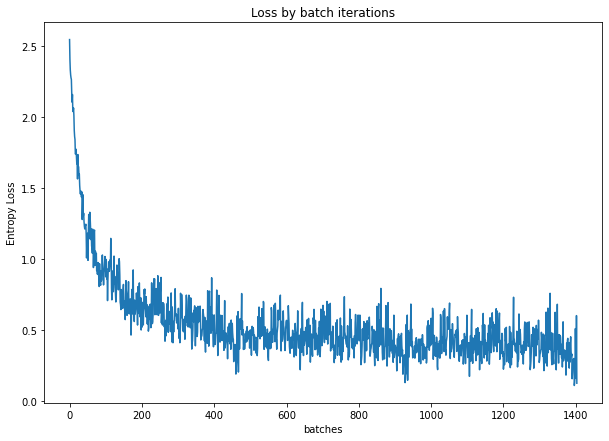

In [15]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
    # load batches of data correctly
    batches += 1
    x_batch = x_batch.view(x_batch.shape[0], -1)
    y_batch = y_batch

    preds = torch.argmax(x_batch @ W, dim=1)
    acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.901


In [19]:
#!pip install torchsummary
import torch.nn as nn
from torchsummary import summary

In [22]:
model = nn.Sequential(
    nn.Linear(features, 64),
    nn.ReLU(),
    nn.Linear(64, classes)
)

# It is the same as:
#
# model = nn.Sequential()
# model.add_module('0', nn.Linear(features, 64))
# model.add_module('1', nn.Linear(64, classes))

model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

In [23]:
summary(model, (features,), batch_size=228)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [228, 64]          50,240
              ReLU-2                  [228, 64]               0
            Linear-3                  [228, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 0.24
Params size (MB): 0.19
Estimated Total Size (MB): 1.12
----------------------------------------------------------------


In [24]:
criterion = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) in its core, applied to logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [26]:
epochs = 3
history = []

In [27]:
for i in range(epochs):
  for x_batch, y_batch in train_loader:
    # 1. load batches of data correctly
    x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
    y_batch = y_batch.to(device)

    # 2. compute scores with .forward or .__call__
    logits = model(x_batch)

    # 3. compute loss
    loss = criterion(logits, y_batch)
    history.append(loss.item())

    # 4. calc gradients
    optimizer.zero_grad()
    loss.backward()

    # 5. step of gradient descent
    optimizer.step()

  print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.08755750209093094
2,	 loss: 0.05253349244594574
3,	 loss: 0.044566575437784195


In [28]:
import matplotlib.pyplot as plt

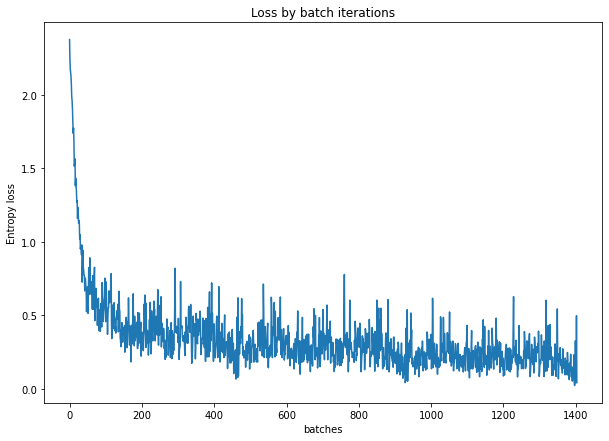

In [29]:
plt.figure(figsize=(10, 7))
plt.plot(history)
plt.title('Loss by batch iterations')
plt.ylabel('Entropy loss')
plt.xlabel('batches')
plt.show()

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
acc = 0
batches = 0

In [32]:
for x_batch, y_batch in test_loader:
    batches += 1
    x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
    y_batch = y_batch.to(device)

    preds = torch.argmax(model(x_batch), dim=1)
    acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.941
